# Практическое задание №2 

## Общая терминология по используемым данным

Предоставляемые данные для разработки моделей и алгоритмов трекинга мяча в теннисе представляют собор набор игр (game), состоящих из нескольких клипов (clip), каждый из которых состоит из набора кадров (frame). Обратите внимание на структуру организации файлов внутри предоставляемого датасета для полного понимания.

Большинство алгоритмов трекинга объектов работают с несколькими последовательными кадрами, и в данном задании также подразумевается использование этого приема. Последовательность нескольких кадров будем именовать стопкой (stack), размер стопки (stack_s) является гиперпараметром разрабатываемого алгоритма.

# Заготовка решения

## Загрузка датасета
Для работы с данными в ноутбуке kaggle необходимо подключить датасет. File -> Add or upload data, далее в поиске написать tennis-tracking-assignment и выбрать датасет. Если поиск не работает, то можно добавить датасет по url: https://www.kaggle.com/xubiker/tennistrackingassignment. После загрузки данные датасета будут примонтированы в ../input/tennistrackingassignment.

## Установка и импорт зависимостей

Установка необходимых пакетов (не забудьте "включить интернет" в настройках ноутбука kaggle):

In [1]:
# !pip install moviepy --no-deps
# !pip install gdown

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy

print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("moviepy:", moviepy.__version__)

numpy: 2.2.6
matplotlib: 3.10.7
moviepy: 2.1.2


Импорт необходимых зависимостей:

In [3]:
from pathlib import Path
from typing import List, Tuple, Sequence

import numpy as np
from numpy import unravel_index
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, notebook

from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import math
from scipy.ndimage import gaussian_filter

import gc
import time
import random
import csv

import gdown

## Набор функций для загрузки данных из датасета

Функция load_clip_data загружает выбранный клип из выбранной игры и возвращает его в виде numpy массива [n_frames, height, width, 3] типа uint8. Для ускорения загрузки используется кэширование - однажды загруженные клипы хранятся на диске в виде npz архивов, при последующем обращении к таким клипам происходит загрузка npz архива.

<font color="red">
Также добавлена возможность чтения клипа в половинном разрешении 640x360, вместо оригинального 1280x720 для упрощения и ускорения разрабатываемых алгоритмов.
</font>

Функция load_clip_labels загружает референсные координаты мяча в клипе в виде numpy массива [n_frames, 4], где в каждой строке массива содержатся значения [code, x, y, q]. x, y соответствуют координате центра мяча на кадре, q не используется в данном задании, code описывает статус мяча:
* code = 0 - мяча в кадре нет
* code = 1 - мяч присутствует в кадре и легко идентифицируем
* code = 2 - мяч присутствует в кадре, но сложно идентифицируем
* code = 3 - мяч присутствует в кадре, но заслонен другими объектами.

При загрузке в половинном разрешении координаты x, y делятся на 2.

Функция load_clip загружает выбранный клип и соответствующий массив координат и возвращает их в виде пары.

In [4]:
def get_num_clips(path: Path, game: int) -> int:
    return len(list((path / f'game{game}/').iterdir()))


def get_game_clip_pairs(path: Path, games: List[int]) -> List[Tuple[int, int]]:
    return [(game, c)  for game in games for c in range(1, get_num_clips(path, game) + 1)]


def load_clip_data(path: Path, game: int, clip: int, downscale: bool, quiet=False) -> np.ndarray:
    if not quiet:
        suffix = 'downscaled' if downscale else ''
        print(f'loading clip data (game {game}, clip {clip}) {suffix}')
    cache_path = path / 'cache'
    cache_path.mkdir(exist_ok=True)
    resize_code = '_ds2' if downscale else ''
    cached_data_name = f'{game}_{clip}{resize_code}.npz'
    if (cache_path / cached_data_name).exists():
        clip_data = np.load(cache_path / cached_data_name)['clip_data']
    else:
        clip_path = path / f'game{game}/clip{clip}'
        n_imgs = len(list(clip_path.iterdir())) - 1
        imgs = [None] * n_imgs
        for i in notebook.tqdm(range(n_imgs)):
            img = Image.open(clip_path / f'{i:04d}.jpg')
            if downscale:
                img = img.resize((img.width // 2, img.height // 2),)
            imgs[i] = np.array(img, dtype=np.uint8)
        clip_data = np.stack(imgs)
        cache_path.mkdir(exist_ok=True, parents=True)
        np.savez_compressed(cache_path / cached_data_name, clip_data=clip_data)
    return clip_data


def load_clip_labels(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    if not quiet:
        print(f'loading clip labels (game {game}, clip {clip})')
    clip_path = path / f'game{game}/clip{clip}'
    labels = []
    with open(clip_path / 'labels.csv') as csvfile:
        lines = list(csv.reader(csvfile))
        for line in lines[1:]:
            values = np.array([-1 if i == '' else int(i) for i in line[1:]])
            if downscale:
                values[1] //= 2
                values[2] //= 2
            labels.append(values)
    return np.stack(labels)


def load_clip(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    data = load_clip_data(path, game, clip, downscale, quiet)
    labels = load_clip_labels(path, game, clip, downscale, quiet)
    return data, labels


## Набор дополнительных функций

Еще несколько функций, немного облегчающих выполнение задания:

* prepare_expariment создает новую директорию в out_path для хранения результатов текущего эксперимента. Нумерация выполняется автоматически, функция возвращает путь к созданной директории эксперимента;
* ball_gauss_template - создает "шаблон" мяча, может быть использована в алгоритмах поиска мяча на изображении по корреляции;
* create_masks - принимает набор кадров и набор координат мяча, и генерирует набор масок, в которых помещает шаблон мяча на заданные координаты. Может быть использована при обучении нейронной сети семантической сегментации;

## Data augmentation

torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([720, 1280, 3])


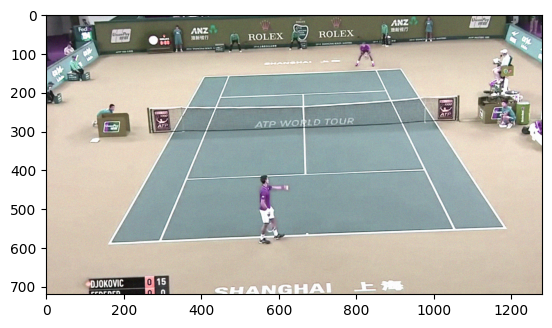

In [5]:
from torchvision import transforms
import torchvision.transforms.v2 as v2

import torch
import torchvision.transforms.v2 as v2
from typing import Optional

import torch
from torchvision.transforms import v2

def clip_augmentations(x: torch.Tensor, mask: torch.Tensor, seed=None):

    if x.dim() == 4:
        B, C, H, W = x.shape
        T = C // 3
        frames = x.view(B, T, 3, H, W)
    elif x.dim() == 5:
        
        B, T, C, H, W = x.shape
        frames = x
    elif x.dim() == 3:
        
        C, H, W = x.shape
        B = 1
        T = C // 3
        frames = x.view(1, T, 3, H, W)
    else:
        raise ValueError(f'shape of clip is {x.shape}')

    
    geom_img = v2.Compose([
        v2.RandomAffine(degrees=2, translate=(0.05, 0.05),
                        scale=(1.0, 1.15), interpolation=v2.InterpolationMode.BILINEAR, fill=0),
        v2.RandomHorizontalFlip(p=0.5),
    ])

    geom_mask = v2.Compose([
        v2.RandomAffine(degrees=2, translate=(0.05, 0.05),
                        scale=(1.0, 1.15), interpolation=v2.InterpolationMode.NEAREST, fill=0),
        v2.RandomHorizontalFlip(p=0.5),
    ])

    img_only = v2.Compose([
        v2.ColorJitter(brightness=(0.85, 1.4), contrast=(0.8, 1.3), saturation=(0.6, 1.2), hue=(-0.3, 0.3)),
        v2.RandomGrayscale(p=0.1),
        v2.GaussianNoise(0.01, 0.03, clip=True),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 0.4)),
    ])

    
    
    x_out = torch.empty_like(frames)

    
    if seed is None:
        s = torch.randint(0, 2**31, ()).item()
    else:
        s = seed

    
    torch.manual_seed(s)
    mask_out = geom_mask(mask) 
    
    for b in range(B):
        for t in range(T):
            torch.manual_seed(s)
            
            f = geom_img(frames[b, t]) 
            f = img_only(f)
            
            x_out[b, t] = torch.clamp(f, 0, 1)
    
    if x.dim() == 3:
        x_out = x_out.view(3*T, H, W)
    else:
        x_out = x_out.view(B, 3*T, H, W)

    if mask_out.dim() == 2:
        mask_out = mask_out.unsqueeze(0)
        
    return x_out, mask_out

plt.figure()
img = Image.open("image.png").convert("RGB")
test_img = torch.from_numpy(np.array(img)).permute(2,0,1).float() / 255.0
print(test_img.shape)


print(test_img.shape)

test_img, mask = clip_augmentations(test_img, test_img, random.randint(1,10000))
test_img = test_img.permute(1,2,0)
print(test_img.shape)
plt.imshow(test_img)

B = 1
T = 1
H, W = 128, 128


x = torch.zeros(B, 3*T, H, W)
x[0, :, 40:80, 50:90] = 1.0


mask = torch.zeros(1, H, W)
mask[0, 40:80, 50:90] = 1.0

x_aug, mask_aug = clip_augmentations(x, mask)

assert x_aug.shape == x.shape, f"x shape changed: {x_aug.shape}"
assert mask_aug.shape == mask.shape, f"mask shape changed: {mask_aug.shape}"

assert 0.0 <= x_aug.min() <= x_aug.max() <= 1.0


In [6]:
def prepare_experiment(out_path: Path) -> Path:
    out_path.mkdir(parents=True, exist_ok=True)
    dirs = [d for d in out_path.iterdir() if d.is_dir() and d.name.startswith('exp_')]
    experiment_id = max(int(d.name.split('_')[1]) for d in dirs) + 1 if dirs else 1
    exp_path = out_path / f'exp_{experiment_id}'
    exp_path.mkdir()
    return exp_path


def ball_gauss_template(rad, sigma):
    x, y = np.meshgrid(np.linspace(-rad, rad, 2 * rad + 1), np.linspace(-rad, rad, 2 * rad + 1)) 
    dst = np.sqrt(x * x + y * y) 
    gauss = np.exp(-(dst ** 2 / (2.0 * sigma ** 2)))     
    return gauss


def create_masks(data: np.ndarray, labels: np.ndarray, resize):
    rad = 64 #25
    sigma = 14
    if resize:
        rad //= 2
    ball = ball_gauss_template(rad, sigma)
    n_frames = data.shape[0]
    sh = rad
    masks = []
    for i in range(n_frames):
        label = labels[i, ...] 
        frame = data[i, ...]
        if 0 < label[0] < 3:
            x, y = label[1:3]
            mask = np.zeros((frame.shape[0] + 2 * rad + 2 * sh, frame.shape[1] + 2 * rad + 2 * sh), np.float32)
            mask[y + sh : y + sh + 2 * rad + 1, x + sh : x + sh + 2 * rad + 1] = ball
            mask = mask[rad + sh : -rad - sh, rad + sh : -rad - sh]
            masks.append(mask)
        else:
            masks.append(np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32))
    return np.stack(masks)


## Набор функций, предназначенных для визуализации результатов

Функция visualize_prediction принимает набор кадров, набор координат детекции мяча (можно подавать как референсные значения, так и предсказанные) и создает видеоклип, в котором отрисовывается положение мяча, его трек, номер кадра и метрика качества трекинга (если она была передана в функцию). Видеоклип сохраняется в виде mp4 файла. Кроме того данная функция создает текстовый файл, в который записывает координаты детекции мяча и значения метрики качества трекинга.

Функция visualize_prob принимает набор кадров и набор предсказанных карт вероятности и создает клип с наложением предсказанных карт вероятности на исходные карты. Области "подсвечиваются" желтым, клип сохраняется в виде mp4 видеофайла. Данная функция может быть полезна при наличии в алгоритме трекинга сети, осуществляющей семантическую сегментацию.

In [7]:
import matplotlib.font_manager as fm
from pathlib import Path

# Find first available TTF font from matplotlib
font_path = Path(fm.findfont('DejaVu Sans'))
print(f"Using font: {font_path}")

def _add_frame_number(frame: np.ndarray, number: int) -> np.ndarray:
    try:
        fnt = ImageFont.truetype(str(font_path), 30)
    except OSError:
        fnt = ImageFont.load_default()
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), f'frame {number}', font=fnt, fill=(255, 0, 255))
    return np.array(img)


def _vis_clip(data: np.ndarray, lbls: np.ndarray, metrics: List[float] = None, ball_rad=5, color=(255, 0, 0), track_length=10):
    print('perfoming clip visualization')
    n_frames = data.shape[0]
    frames_res = []
    try:
        fnt = ImageFont.truetype(str(font_path), 30)
    except OSError:
        fnt = ImageFont.load_default()
    for i in range(n_frames):
        img = Image.fromarray(data[i, ...])
        draw = ImageDraw.Draw(img)
        txt = f'frame {i}'
        if metrics is not None:
            txt += f', SiBaTrAcc: {metrics[i]:.3f}'
        draw.text((10, 10), txt, font=fnt, fill=(255, 0, 255))
        label = lbls[i]
        if label[0] != 0: # the ball is clearly visible
            px, py = label[1], label[2]
            draw.ellipse((px - ball_rad, py - ball_rad, px + ball_rad, py + ball_rad), outline=color, width=2)
            for q in range(track_length):
                if lbls[i-q-1][0] == 0:
                    break
                if i - q > 0:
                    draw.line((lbls[i - q - 1][1], lbls[i - q - 1][2], lbls[i - q][1], lbls[i - q][2]), fill=color)                
        frames_res.append(np.array(img))
    return frames_res


def _save_clip(frames: Sequence[np.ndarray], path: Path, fps):
    assert path.suffix in ('.mp4', '.gif')
    clip = ImageSequenceClip(frames, fps=fps)
    if path.suffix == '.mp4':
        clip.write_videofile(str(path), fps=fps, logger=None)
    else:
        clip.write_gif(str(path), fps=fps, logger=None)


def _to_yellow_heatmap(frame: np.ndarray, pred_frame: np.ndarray, alpha=0.4):
    img = Image.fromarray((frame * alpha).astype(np.uint8))
    maskR = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskG = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskB = np.zeros_like(maskG, dtype=np.uint8)
    mask = np.stack([maskR, maskG, maskB], axis=-1)
    return img + mask


def _vis_pred_heatmap(data_full: np.ndarray, pred_prob: np.ndarray, display_frame_number):
    n_frames = data_full.shape[0]
    v_frames = []
    for i in range(n_frames):
        frame = data_full[i, ...]
        pred = pred_prob[i, ...]
        hm = _to_yellow_heatmap(frame, pred)
        if display_frame_number:
            hm = _add_frame_number(hm, i)
        v_frames.append(hm)
    return v_frames


def visualize_prediction(data_full: np.ndarray, labels_pr: np.ndarray, save_path: Path, name: str, metrics=None, fps=15):
    with open(save_path / f'{name}.txt', mode='w') as f:
        if metrics is not None:
            f.write(f'SiBaTrAcc: {metrics[-1]} \n')
        for i in range(labels_pr.shape[0]):
            f.write(f'frame {i}: {labels_pr[i, 0]}, {labels_pr[i, 1]}, {labels_pr[i, 2]} \n')

    v = _vis_clip(data_full, labels_pr, metrics)
    _save_clip(v, save_path / f'{name}.mp4', fps=fps)


def visualize_prob(data: np.ndarray, pred_prob: np.ndarray, save_path: Path, name: str, frame_number=True, fps=15):
    v_pred = _vis_pred_heatmap(data, pred_prob, frame_number)
    _save_clip(v_pred, save_path / f'{name}_prob.mp4', fps=fps)


Using font: C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf


## Класс DataGenerator 

Класс, отвечающий за генерацию данных для обучения модели. Принимает на вход путь к директории с играми, индексы игр, используемые для генерации данных, и размер стопки. Хранит в себе автоматически обновляемый пул с клипами игр.

В пуле содержится pool_s клипов. DataGenerator позволяет генерировать батч из стопок (размера stack_s) последовательных кадров. Выбор клипа для извлечения данных взвешенно-случайный: чем больше длина клипа по сравнению с другими клипами в пуле, тем вероятнее, что именно из него будет сгенерирована стопка кадров. Выбор стопки кадров внтури выбранного клипа полностью случаен. Кадры внутри стопки конкатенируются по последнему измерению (каналам).

После генерирования количества кадров равного общему количеству кадров, хранимых в пуле, происходит автоматическое обновление пула: из пула извлекаются pool_update_s случайных клипов, после чего в пул загружается pool_update_s случайных клипов, не присутствующих в пуле. В случае, если размер пула pool_s больше или равен суммарному количеству клипов в играх, переданных в конструктор, все клипы сразу загружаются в пул, и автообновление не производится.

Использование подобного пула позволяет работать с практически произвольным количеством клипов, без необходимости загружать их всех в оперативную память.

Для вашего удобства функция извлечения стопки кадров из пула помимо самой стопки также создает и возвращает набор сгенерированных масок с мячом исходя из референсных координат мяча в клипе.

Функция random_g принимает гиперпараметр размера стопки кадров и предоставляет генератор, возвращающий стопки кадров и соответствующие им маски. Данный генератор может быть использован при реализации решения на tensorflow. Обновление пула происходит автоматически, об этом беспокоиться не нужно.

In [8]:
class DataGenerator:

    def __init__(self, path: Path, games: List[int], stack_s, downscale, pool_s=30, pool_update_s=10, pool_autoupdate=True, quiet=False) -> None:
        self.path = path
        self.stack_s = stack_s
        self.downscale = downscale
        self.pool_size = pool_s
        self.pool_update_size = pool_update_s
        self.pool_autoupdate = pool_autoupdate
        self.quiet = quiet
        self.data = []
        self.masks = []

        self.frames_in_pool = 0
        self.produced_frames = 0
        self.game_clip_pairs = get_game_clip_pairs(path, list(set(games)))
        self.game_clip_pairs_loaded = []
        self.game_clip_pairs_not_loaded = list.copy(self.game_clip_pairs) 
        self.pool = {}

        self._first_load()

    def _first_load(self):
        # --- if all clips can be placed into pool at once, there is no need to refresh pool at all ---
        if len(self.game_clip_pairs) <= self.pool_size:
            for gcp in self.game_clip_pairs:
                self._load(gcp)
            self.game_clip_pairs_loaded = list.copy(self.game_clip_pairs)
            self.game_clip_pairs_not_loaded.clear()
            self.pool_autoupdate = False
        else:
            self._load_to_pool(self.pool_size)        
        self._update_clip_weights()

    def _load(self, game_clip_pair):
        game, clip = game_clip_pair
        data, labels = load_clip(self.path, game, clip, self.downscale, quiet=self.quiet)
        masks = create_masks(data, labels, self.downscale)
        weight = data.shape[0] if data.shape[0] >= self.stack_s else 0
        self.pool[game_clip_pair] = (data, labels, masks, weight)
        self.frames_in_pool += data.shape[0] - self.stack_s + 1
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _remove(self, game_clip_pair):
        value = self.pool.pop(game_clip_pair)
        self.frames_in_pool -= value[0].shape[0] - self.stack_s + 1
        del value
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _update_clip_weights(self):
        weights = [self.pool[pair][-1] for pair in self.game_clip_pairs_loaded]
        tw = sum(weights)
        self.clip_weights = [w / tw for w in weights]
        # print(f'clip weights: {self.clip_weights}')

    def _remove_from_pool(self, n):
        # --- remove n random clips from pool ---
        if len(self.game_clip_pairs_loaded) >= n:
            remove_pairs = random.sample(self.game_clip_pairs_loaded, n)
            for pair in remove_pairs:
                self._remove(pair)
                self.game_clip_pairs_loaded.remove(pair)
                self.game_clip_pairs_not_loaded.append(pair)
            gc.collect()

    def _load_to_pool(self, n):
        # --- add n random clips to pool ---
        gc.collect()
        add_pairs = random.sample(self.game_clip_pairs_not_loaded, n)
        for pair in add_pairs:
            self._load(pair)
            self.game_clip_pairs_not_loaded.remove(pair)
            self.game_clip_pairs_loaded.append(pair)

    def update_pool(self):
        self._remove_from_pool(self.pool_update_size)
        self._load_to_pool(self.pool_update_size)
        self._update_clip_weights()

    def get_random_stack(self):
        pair_idx = np.random.choice(len(self.game_clip_pairs_loaded), 1, p=self.clip_weights)[0]
        game_clip_pair = self.game_clip_pairs_loaded[pair_idx]
        d, labels, m, _ = self.pool[game_clip_pair]

        start = np.random.choice(d.shape[0] - self.stack_s, 1)[0]

        frames_stack = d[start : start + self.stack_s, ...]
        frames_stack = np.squeeze(np.split(frames_stack, indices_or_sections=self.stack_s, axis=0))
        frames_stack = np.concatenate(frames_stack, axis=-1)

        mask = m[start + self.stack_s - 1, ...]

        idx = start + self.stack_s - 1
        label = labels[idx]
        return frames_stack, mask, label

    def get_random_batch(self, batch_s):
        imgs, masks, labels = [], [], []
        while len(imgs) < batch_s:
            frames_stack, mask, label = self.get_random_stack()
            imgs.append(frames_stack)
            masks.append(mask)
            labels.append(label)
        if self.pool_autoupdate:
            self.produced_frames += batch_s
            # print(f'produced frames: {self.produced_frames} from {self.frames_in_pool}')
            if self.produced_frames >= self.frames_in_pool:
                self.update_pool()
                self.produced_frames = 0
        return np.stack(imgs), np.stack(masks), np.stack(labels)

    def random_g(self, batch_s):
        while True:
            imgs_batch, masks_batch, labels_batch = self.get_random_batch(batch_s)
            yield imgs_batch, masks_batch, labels_batch


# Torch Imports

In [9]:
import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torch import nn

# Torch wrap

In [10]:
import random
from torchvision.transforms.functional import hflip
class PyTorchWrap(TorchDataset):

    def __init__(self, base_dataset, mode= "eval"):
        self.generator = base_dataset
        self._length = 10_000_000
        self.mode = mode

    def __len__(self) -> int:
        return self._length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:

        frames_stack, mask, labels = self.generator.get_random_stack()
        
        frames_stack = frames_stack.astype(np.float32) / 255.0
            
        mask = mask.astype(np.float32)

        img_tensor = torch.from_numpy(frames_stack).permute(2, 0, 1)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        v_tensor = torch.tensor(labels[0], dtype=torch.long)

        

        if self.mode == "train" and random.random() < 0.0:
            seed = random.randint(0, 100)
            img_tensor, mask_tensor = clip_augmentations(img_tensor, mask_tensor, seed)

        return img_tensor, mask_tensor, v_tensor

### Пример использования DataGenerator

Рекомендованный размер пула pool_s=10 в случае использования уменьшенных вдвое изображений. При большем размере пула есть большая вероятность нехватки имеющихся 13G оперативной памяти.
Используйте параметр quiet=True в конструкторе DataGenerator, если хотите скрыть все сообщения о чтении данных и обновлении пула.

In [11]:
# stack_s = 8
# batch_s = 4
# train_gen = DataGenerator(Path('data/train'), [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
# for i in range(10):
#     imgs, masks, _ = train_gen.get_random_batch(batch_s)
#     print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)
    

In [12]:
import matplotlib.pyplot as plt

# stack_s = 8
# train_gen = DataGenerator(Path('data/test'), [1], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
# stack, mask, _ = train_gen.get_random_stack()
# print(stack.shape, mask.shape)

# for i in range(stack_s):
#     plt.figure()
#     plt.imshow(stack[:, :, 3 * i: 3 * i + 3])

## Класс Metrics
Класс для вычисления метрики качества трекинга SiBaTrAcc. Функция evaluate_predictions принимает массив из референсных и предсказанных координат мяча для клипа и возвращает массив аккумулированных значений SiBaTrAcc (может быть полезно для визуализации результатов предсказания) и итоговое значение метрики SiBaTrAcc.

In [13]:
class Metrics:

    @staticmethod
    def position_error(label_gt: np.ndarray, label_pr: np.ndarray, step=8, alpha=1.5, e1=5, e2=5):
        # gt codes:
        # 0 - the ball is not within the image
        # 1 - the ball can easily be identified
        # 2 - the ball is in the frame, but is not easy to identify
        # 3 - the ball is occluded
        if label_gt[0] != 0 and label_pr[0] == 0:
            return e1
        if label_gt[0] == 0 and label_pr[0] != 0:
            return e2
        dist = math.sqrt((label_gt[1] - label_pr[1]) ** 2 + (label_gt[2] - label_pr[2]) ** 2)
        pe = math.floor(dist / step) ** alpha
        pe = min(pe, 5)
        return pe

    @staticmethod
    def evaluate_predictions(labels_gt, labels_pr) -> Tuple[List[float], float]:
        pe = [Metrics.position_error(labels_gt[i, ...], labels_pr[i, ...]) for i in range(len(labels_gt))]
        SIBATRACC = []
        for i, _ in enumerate(pe):
            SIBATRACC.append(1 - sum(pe[: i + 1]) / ((i + 1) * 5))
        SIBATRACC_total = 1 - sum(pe) / (len(labels_gt) * 5)
        return SIBATRACC, SIBATRACC_total


## Основной класс модели SuperTrackingModel

Реализует всю логику обучения, сохранения, загрузки и тестирования разработанной модели трекинга. Этот класс можно и нужно расширять.

В качестве примера вам предлагается заготовка модели, в которой трекинг осуществляется за счет предсказания маски по входному батчу и последующему предсказанию координат мяча по полученной маски. В данном варианте вызов функции предсказания координат по клипу (predict) повлечет за собой разбиение клипа на батчи, вызов предсказания маски для каждого батча, склеивание результатов в последовательность масок, вызов функции по вычислению координат мяча по маскам и возвращения результата. Описанные действия уже реализованы, вам остается только написать функции predict_on_bath и get_labels_from_prediction. Эта же функция predict используется и в вызове функции test, дополнительно вычисляя метрику качества трекинга и при необходимости визуализируя результат тестирования. Обратите внимание, что в результирующем numpy массиве с координатами помимо значений x и y первым значением в каждой строке должно идти значение code (0, если мяча в кадре нет и > 0, если мяч в кадре есть) для корректного вычисления качества трекинга.

<font color="red">
Вам разрешается менять логику работы класса модели, (например, если решение не подразумевает использование масок), но при этом логика и работа функций load и test должна остаться неизменной!
</font>

In [14]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        return (self.alpha * (1 - pt) ** self.gamma * bce).mean()

class DiceLoss(nn.Module):
    def forward(self, probs, targets, smooth=1.0):
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        intersection = (probs * targets).sum(1)
        dice = 1 - (2 * intersection + smooth) / (probs.sum(1) + targets.sum(1) + smooth)
        return dice.mean()
    
def area_regularization(mask: torch.Tensor, target_ratio=0.003):
    area = mask.mean()
    return (area - target_ratio).abs()
    

In [15]:
import torch.nn as nn

class ConvBlock(nn.Module):
    """Helper block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    def __init__(self, in_c, out_c, dilation=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=dilation, dilation=dilation),
            nn.GroupNorm(8, out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=dilation, dilation=dilation),
            nn.GroupNorm(8, out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SuperTrackingModel(nn.Module):
    def __init__(self, batch_s, stack_s, out_path, downscale, threshold):
        super().__init__()
        self.batch_s = batch_s
        self.stack_s = stack_s
        self.out_path = out_path
        self.downscale = downscale
        self.threshold = threshold
        
        input_channels = 3 * stack_s 

        self.enc1 = ConvBlock(input_channels, 32)
        self.pool1 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        self.bottleneck = ConvBlock(64, 128)

        # Up 1: 1/4 -> 1/2
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(128 + 64, 64) 

        # Up 2: 1/2 -> Full
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(64 + 32, 32) 

        self.final = nn.Conv2d(32, 1, 1)

        # self.gap = nn.AdaptiveAvgPool2d(1)
        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 4)
        # )

    def forward(self, x):
        
        e1 = self.enc1(x)       # [B, 32, H, W]
        p1 = self.pool1(e1)     # [B, 32, H/2, W/2]
        
        e2 = self.enc2(p1)      # [B, 64, H/2, W/2]
        p2 = self.pool2(e2)     # [B, 64, H/4, W/4]

        b = self.bottleneck(p2) # [B, 128, H/4, W/4]

        d1 = self.up1(b)        # [B, 128, H/2, W/2]
        d1 = torch.cat([d1, e2], dim=1) 
        d1 = self.dec1(d1)      # [B, 64, H/2, W/2]

        d2 = self.up2(d1)       # [B, 64, H, W]
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)      # [B, 32, H, W]

        mask = self.final(d2) # [B, 1, H, W]
        
        # v_logits = self.classifier(self.gap(b)) # [B, 4]

        # v = 1 ALWAYS
        # for i in range(8):
        #     v_logits[i][1] = 1.0
        #     v_logits[i][0] = 0.0
        #     v_logits[i][2] = 0.0
        #     v_logits[i][3] = 0.0
        v_logits = torch.zeros(b.size(0), 4, device=b.device)
        v_logits[:, 1] = 1.0

        return mask, v_logits
        
    def save_weights(self, path="model.pth"):
        torch.save(self.state_dict(), path)

    def load_weights(self, path, device=None):
        self.load_state_dict(torch.load(path, map_location=device, weights_only=False))

    def load(self, link, device):
        # todo: add code for loading model here
        print('Running stub for loading model ...')
        output = 'model.pth'
        gdown.download(link, output, quiet=False)
        self.load_weights(output, device)
        print('Loading model done.')

    def predict_on_batch(self, batch: np.ndarray) -> np.ndarray:
        """
        Input: [B, H, W, C]  (C = 3 * stack_s)
        Output:[B, H, W]
        """
        # to tensor + layout
        x = torch.from_numpy(batch).to(next(self.parameters()).device)
        x = x.permute(0, 3, 1, 2).float()

        with torch.no_grad():
            mask, v_logits = self(x)

        mask = torch.sigmoid(mask) 
        mask = mask.squeeze(1).cpu().numpy()
        v = torch.argmax(v_logits, dim=1).cpu().numpy()

        #############
        # v = 1 ####### !!!!!!!!!!!!!!!!!
        #############

        return mask, v

    def mask_to_coords(self, mask):
        if isinstance(mask, torch.Tensor):
            mask = torch.relu(mask - self.threshold) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            mask = mask.cpu().detach().numpy()
        else:
            mask = (mask > 0.15).astype(np.float32)
        
        if mask.ndim == 3: mask = mask[0]
        
        if mask.max() < self.threshold:
            return None

        total_mass = mask.sum()
        if total_mass <= 0: return None
        
        # coordinate grids
        grid_y, grid_x = np.indices(mask.shape)
        
        #  Centroid
        x = (grid_x * mask).sum() / total_mass
        y = (grid_y * mask).sum() / total_mass
        
        return x, y
    
        
        
    def _predict_prob_on_clip(self, clip: np.ndarray) -> np.ndarray:
        print('doing predictions')
        n_frames = clip.shape[0]
        print(f'stack_s: {stack_s} n_frames: {n_frames}')
        # --- get stacks ---
        stacks = []
        for i in range(n_frames - self.stack_s + 1):
            stack = clip[i : i + self.stack_s, ...]
            stack = np.squeeze(np.split(stack, self.stack_s, axis=0))
            stack = np.concatenate(stack, axis=-1)
            stacks.append(stack)
        # --- round to batch size ---
        add_stacks = 0
        while len(stacks) % self.batch_s != 0:
            stacks.append(stacks[-1])
            add_stacks += 1
        # --- group into batches ---
        batches = []
        for i in range(len(stacks) // self.batch_s):
            batch = np.stack(stacks[i * self.batch_s : (i + 1) * self.batch_s])
            batches.append(batch)
        stacks.clear()
        # --- perform predictions ---
        predictions = []
        pred_v = []
        for batch in batches:
            pred_mask, v = self.predict_on_batch(batch)
            predictions.append(pred_mask)
            pred_v.append(v)
        # --- crop back to source length ---
        predictions = np.concatenate(predictions, axis=0)
        if (add_stacks > 0):
            predictions = predictions[:-add_stacks, ...]
        batches.clear()
        # --- add (stack_s - 1) null frames at the begining ---
        start_frames = np.zeros((stack_s - 1, predictions.shape[1], predictions.shape[2]), dtype=np.float32)
        predictions = np.concatenate((start_frames, predictions), axis=0)
        pred_v = np.concatenate(pred_v, axis=0)
        pad_v = np.zeros(self.stack_s - 1, dtype=np.int64)
        pred_v = np.concatenate([pad_v, pred_v])
        print('predictions are made')        
        return predictions, pred_v

    def get_labels_from_prediction(self, pred_prob, v, upscale_coords):
        n_frames = pred_prob.shape[0]
        coords = np.zeros((n_frames, 4), dtype=np.float32)

        for i in range(n_frames):
            xy = self.mask_to_coords(pred_prob[i])

            if xy is None:
                coords[i] = [0, 0, 0, 0]
                continue

            x, y = xy

            if upscale_coords:
                x *= 2
                y *= 2

            coords[i] = [1, x, y, 0]

        return coords


    def predict(self, clip: np.ndarray, upscale_coords=True):
        pred_masks, pred_vs = self._predict_prob_on_clip(clip)
        labels_pr = self.get_labels_from_prediction(pred_masks, pred_vs, upscale_coords)
        return labels_pr, pred_masks

    def test(self, data_path: Path, games: List[int], do_visualization=False, test_name='test'):
        self.eval()
        with torch.no_grad():
            game_clip_pairs = get_game_clip_pairs(data_path, games)
            SIBATRACC_vals = []
            for game, clip in game_clip_pairs:
                data = load_clip_data(data_path, game, clip, downscale=self.downscale)
                if do_visualization:
                    data_full = load_clip_data(data_path, game, clip, downscale=False) if self.downscale else data
                labels_gt = load_clip_labels(data_path, game, clip, downscale=False)
                labels_pr, prob_pr = self.predict(data, upscale_coords=self.downscale)
                SIBATRACC_per_frame, SIBATRACC_total = Metrics.evaluate_predictions(labels_gt, labels_pr)
                SIBATRACC_vals.append(SIBATRACC_total)
                if do_visualization:
                    visualize_prediction(data_full, labels_pr, self.out_path, f'{test_name}_g{game}_c{clip}', SIBATRACC_per_frame)
                    visualize_prob(data, prob_pr, self.out_path, f'{test_name}_g{game}_c{clip}')
                    del data_full
                del data, labels_gt, labels_pr, prob_pr
                gc.collect()
            SIBATRACC_final = sum(SIBATRACC_vals) / len(SIBATRACC_vals)
        return SIBATRACC_final

    def train_on_data(self,
        train_loader,
        val_loader,
        device,
        max_epochs=10,
        patience=5,
        lr = 3e-4,
        num_of_steps = 200):
        
        # todo: implement model training here
        print('Running stub for training model...')

        optimazer = torch.optim.Adam(self.parameters(), lr=lr)
        # criterion = DiceBCELoss()
        criterion_v = torch.nn.CrossEntropyLoss()

        best_loss = 9999.0
        epoch_no_imp = 0

        self.train()

        # img, mask, _ = train_gen.get_random_batch(1)

        # img = torch.from_numpy(img).permute(0,3,1,2).float().to(device)
        # mask = torch.from_numpy(mask).unsqueeze(1).float().to(device)

        # for i in range(200):
        #     pred, _ = self(img)
        #     loss = F.mse_loss(torch.sigmoid(pred), mask)
        #     loss.backward()
        #     optimazer.step()
        #     optimazer.zero_grad()

        # print(loss.item())
        start_augmenting = False

        for epoch in range(max_epochs):
            i = 0

            # train_loop = notebook.tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=False)
            train_iter = iter(train_loader)
            bar = tqdm(range(num_of_steps))
            total_loss = 0
            alt_total = 0

            for step in bar:
                if i >= num_of_steps:
                    break

                    

                clip, gt_mask, gt_v = next(train_iter)
                if clip.shape[0] < 2:
                    continue
                
                optimazer.zero_grad()
                clip, gt_mask, gt_v = clip.to(device), gt_mask.to(device), gt_v.to(device)

                if start_augmenting and random.random() < 0.95:
                    try:
                        clip, gt_mask = clip_augmentations(clip, gt_mask, random.randint(1, 2**30))
                    except:
                        print(f"failed to augment clip {clip.shape, gt_mask.shape}")
                    
                
    
                pred_mask, v_logits = self(clip)
                prob = torch.sigmoid(pred_mask)
                

                if gt_mask.dim() == 3:
                    gt_mask = gt_mask.unsqueeze(1)

                area_w = min(0.06, (epoch / 3) * 0.06)
                loss = 0.15*DiceLoss()(prob, gt_mask) + 0.77*FocalLoss()(pred_mask, gt_mask) + area_w * area_regularization(prob)

                total_loss += loss
                loss.backward()
                optimazer.step()

            tqdm.write(f'Epoch is {epoch} Total train loss is {total_loss / num_of_steps :.4f}')
            total_loss = 0

            val_iter = iter(val_loader)
            vbar = tqdm(range(num_of_steps // 4))
            for step in vbar:
                if i >= num_of_steps:
                    break

                with torch.no_grad():
                    clip, gt_mask, gt_v = next(val_iter)
                    if clip.shape[0] < 2:
                        continue
            
                    optimazer.zero_grad()
                    clip, gt_mask, gt_v = clip.to(device), gt_mask.to(device), gt_v.to(device)
                    pred_mask, v_logits = self(clip)
                    prob = torch.sigmoid(pred_mask)
                    

                    if step == 10:
                        plt.imshow(pred_mask[0].cpu().squeeze(0), cmap='plasma')
                        plt.show()
                    if step == 9:
                        plt.close('all')

                    if gt_mask.dim() == 3:
                        gt_mask = gt_mask.unsqueeze(1)

                    # loss =  0.7 * F.mse_loss(pred_mask, gt_mask) + 0.3 * F.l1_loss(pred_mask, gt_mask)
                    loss = 0.3*DiceLoss()(prob, gt_mask) + 0.67*FocalLoss()(pred_mask, gt_mask) + area_w * area_regularization(prob)
                    # pred_v = torch.argmax(v_logits)

                    # v_loss = criterion_v(v_logits, gt_v.long())

                    total_loss += loss


            if total_loss / (num_of_steps // 4) < 0.22 or epoch > 10:
                tqdm.write("STARTING TO AUGMENT!!!!")
                start_augmenting = True

            if total_loss < best_loss:
                best_loss = total_loss
                epoch_no_imp = 0
                self.save_weights('best_model.pth')
            else:
                epoch_no_imp += 1
            
            tqdm.write(f'Total val loss is {total_loss / (num_of_steps // 4) :.4f} Epoch without improvment {epoch_no_imp}/{patience}\n')
            if epoch_no_imp > patience:
                tqdm.write(f"patince is over. training is over. smallestt loss is {best_loss / (num_of_steps // 4) :.4f}")
                break
                
            
            i += 1
        self.save_weights('last_epoch.pth')
        
        print('training done.')

Пример пайплайна для обучения модели:

# Глобальные переменные !!!

In [16]:
LR = 7e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_EPOCHS = 45
STACK_S = 8
BATCH_S = 8
THRESHOLD = 0.3
NUM_OF_STEPS = 300
PATIENCE = 6
batch_s = BATCH_S
stack_s = STACK_S
downscale = True
output_path = prepare_experiment(Path('out_path'))
print(device)

cuda


In [17]:


model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale, threshold = THRESHOLD)
model.to(device)


SuperTrackingModel(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bottleneck): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, ke

In [18]:
train_gen = DataGenerator(Path('data/train'), [1, 2, 3], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
val_gen = DataGenerator(Path('data/train'), [4], stack_s=stack_s, downscale=True, pool_s=4, pool_update_s=2, quiet=False)

train_l = DataLoader(PyTorchWrap(train_gen, mode="train"), batch_size=BATCH_S, shuffle=False)
val_l = DataLoader(PyTorchWrap(val_gen), batch_size=BATCH_S, shuffle=False)

loading clip data (game 2, clip 1) downscaled
loading clip labels (game 2, clip 1)
loading clip data (game 2, clip 7) downscaled
loading clip labels (game 2, clip 7)
loading clip data (game 3, clip 2) downscaled
loading clip labels (game 3, clip 2)
loading clip data (game 1, clip 12) downscaled
loading clip labels (game 1, clip 12)
loading clip data (game 3, clip 7) downscaled
loading clip labels (game 3, clip 7)
loading clip data (game 1, clip 9) downscaled
loading clip labels (game 1, clip 9)
loading clip data (game 1, clip 6) downscaled
loading clip labels (game 1, clip 6)
loading clip data (game 2, clip 6) downscaled
loading clip labels (game 2, clip 6)
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
loading clip data (game 3, clip 5) downscaled
loading clip labels (game 3, clip 5)
loading clip data (game 4, clip 11) downscaled
loading clip labels (game 4, clip 11)
loading clip data (game 4, clip 7) downscaled
loading clip labels (game 4, clip 7)


Running stub for training model...


100%|██████████| 300/300 [00:56<00:00,  5.27it/s]


Epoch is 0 Total train loss is 0.1509


 13%|█▎        | 10/75 [00:01<00:11,  5.88it/s]

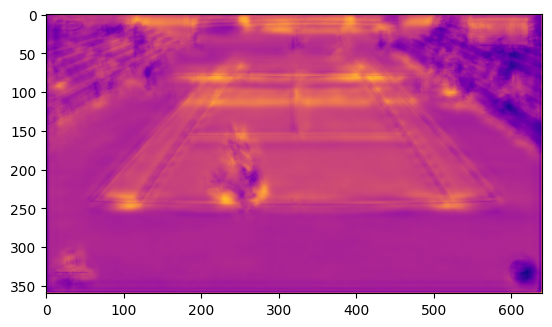

100%|██████████| 75/75 [00:12<00:00,  5.87it/s]


Total val loss is 0.2983 Epoch without improvment 0/6



100%|██████████| 300/300 [00:56<00:00,  5.31it/s]


Epoch is 1 Total train loss is 0.1521


 13%|█▎        | 10/75 [00:01<00:11,  5.70it/s]

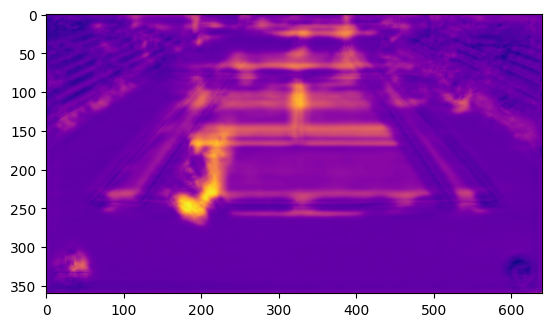

100%|██████████| 75/75 [00:13<00:00,  5.77it/s]


Total val loss is 0.2997 Epoch without improvment 1/6



100%|██████████| 300/300 [00:56<00:00,  5.32it/s]


Epoch is 2 Total train loss is 0.1519


 13%|█▎        | 10/75 [00:01<00:10,  6.06it/s]

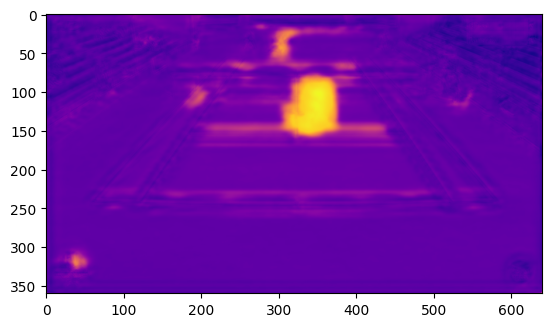

100%|██████████| 75/75 [00:13<00:00,  5.74it/s]


Total val loss is 0.3009 Epoch without improvment 2/6



100%|██████████| 300/300 [00:56<00:00,  5.32it/s]


Epoch is 3 Total train loss is 0.1502


 13%|█▎        | 10/75 [00:01<00:10,  5.95it/s]

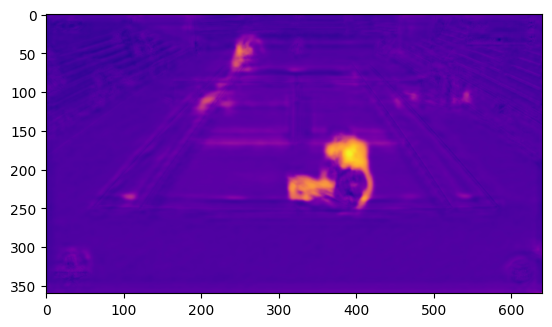

100%|██████████| 75/75 [00:13<00:00,  5.74it/s]


Total val loss is 0.2986 Epoch without improvment 3/6



100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


Epoch is 4 Total train loss is 0.1390


 13%|█▎        | 10/75 [00:01<00:11,  5.66it/s]

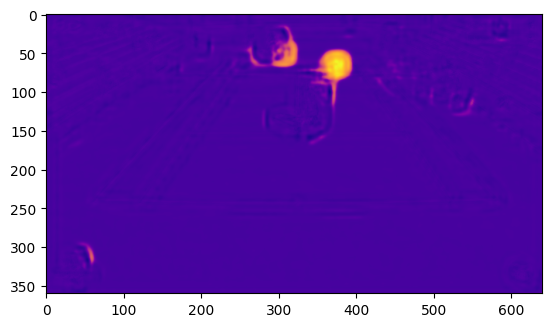

100%|██████████| 75/75 [00:12<00:00,  5.78it/s]


Total val loss is 0.2634 Epoch without improvment 0/6



100%|██████████| 300/300 [00:56<00:00,  5.32it/s]


Epoch is 5 Total train loss is 0.1179


 13%|█▎        | 10/75 [00:01<00:11,  5.83it/s]

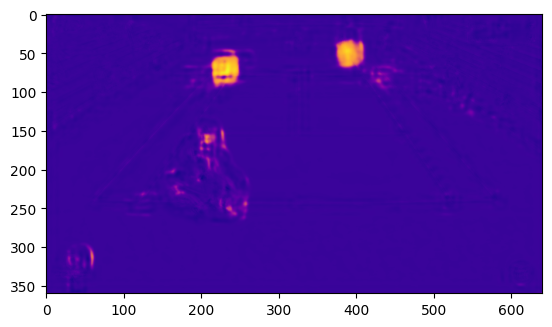

100%|██████████| 75/75 [00:12<00:00,  5.85it/s]


Total val loss is 0.2368 Epoch without improvment 0/6



100%|██████████| 300/300 [00:56<00:00,  5.31it/s]


Epoch is 6 Total train loss is 0.1005


 13%|█▎        | 10/75 [00:01<00:11,  5.66it/s]

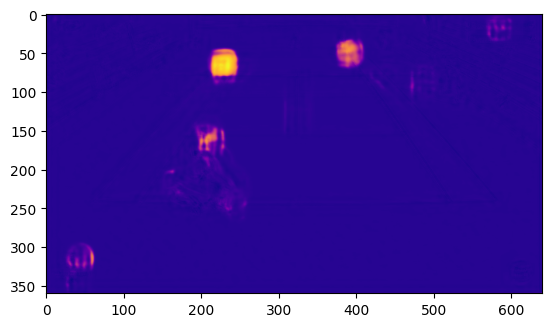

100%|██████████| 75/75 [00:12<00:00,  5.78it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.2072 Epoch without improvment 0/6



100%|██████████| 300/300 [01:40<00:00,  2.97it/s]


Epoch is 7 Total train loss is 0.0978


 13%|█▎        | 10/75 [00:01<00:11,  5.76it/s]

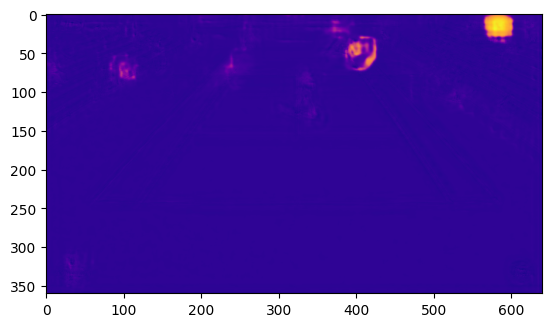

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1878 Epoch without improvment 0/6



100%|██████████| 300/300 [01:42<00:00,  2.94it/s]


Epoch is 8 Total train loss is 0.0886


 13%|█▎        | 10/75 [00:01<00:11,  5.82it/s]

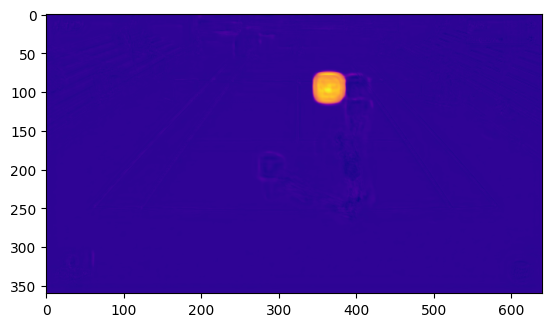

100%|██████████| 75/75 [00:13<00:00,  5.69it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1647 Epoch without improvment 0/6



100%|██████████| 300/300 [01:41<00:00,  2.97it/s]


Epoch is 9 Total train loss is 0.0820


 13%|█▎        | 10/75 [00:01<00:11,  5.74it/s]

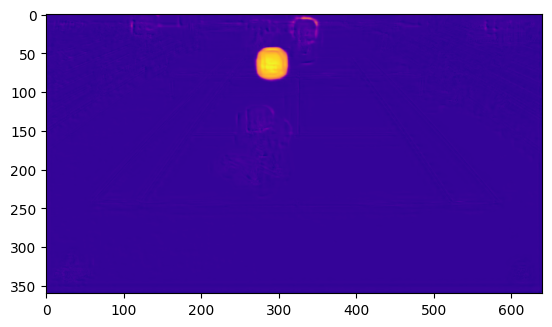

100%|██████████| 75/75 [00:13<00:00,  5.68it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1605 Epoch without improvment 0/6



100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


Epoch is 10 Total train loss is 0.0814


 13%|█▎        | 10/75 [00:01<00:11,  5.89it/s]

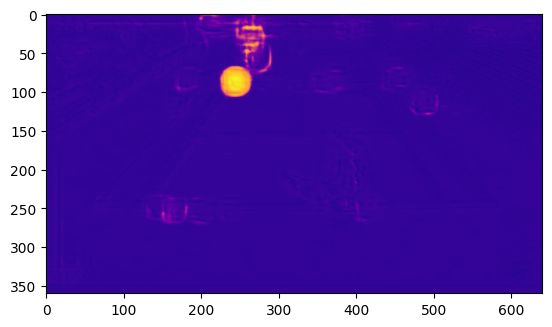

100%|██████████| 75/75 [00:12<00:00,  5.77it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1490 Epoch without improvment 0/6



100%|██████████| 300/300 [01:41<00:00,  2.95it/s]


Epoch is 11 Total train loss is 0.0786


 13%|█▎        | 10/75 [00:01<00:11,  5.61it/s]

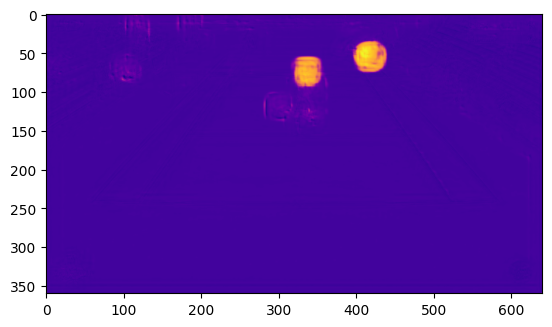

100%|██████████| 75/75 [00:13<00:00,  5.74it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1547 Epoch without improvment 1/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 12 Total train loss is 0.0788


 13%|█▎        | 10/75 [00:01<00:11,  5.74it/s]

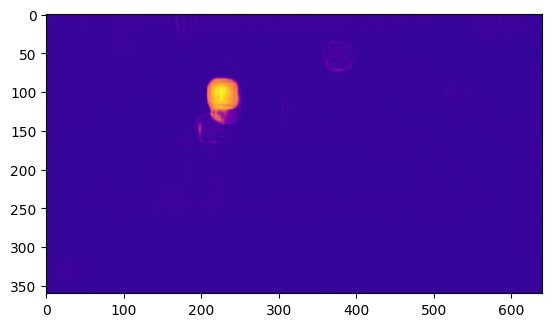

100%|██████████| 75/75 [00:13<00:00,  5.68it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1509 Epoch without improvment 2/6



100%|██████████| 300/300 [01:39<00:00,  3.00it/s]


Epoch is 13 Total train loss is 0.0762


 13%|█▎        | 10/75 [00:01<00:11,  5.89it/s]

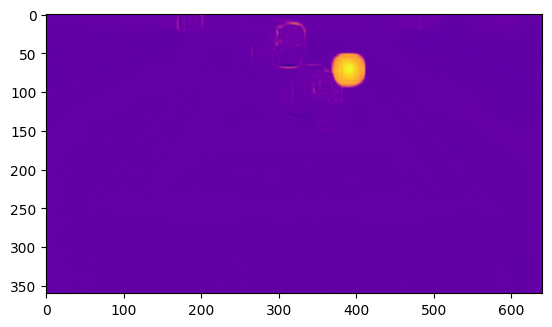

100%|██████████| 75/75 [00:13<00:00,  5.62it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1433 Epoch without improvment 0/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 14 Total train loss is 0.0760


 13%|█▎        | 10/75 [00:01<00:10,  5.99it/s]

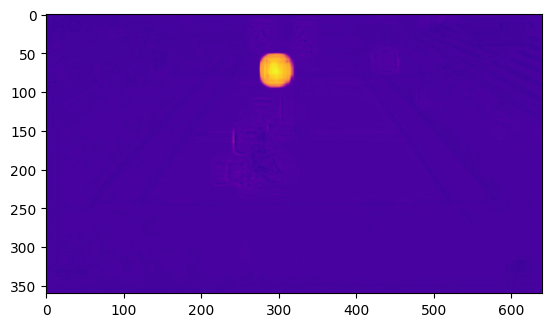

100%|██████████| 75/75 [00:13<00:00,  5.62it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1400 Epoch without improvment 0/6



100%|██████████| 300/300 [01:40<00:00,  2.97it/s]


Epoch is 15 Total train loss is 0.0741


 13%|█▎        | 10/75 [00:01<00:11,  5.69it/s]

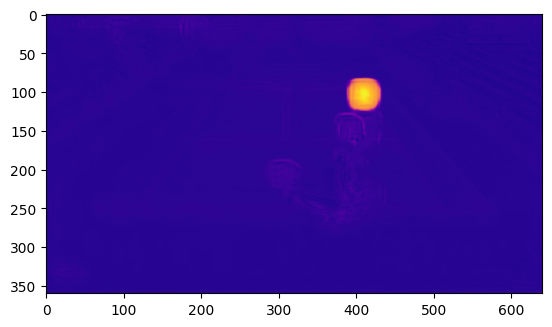

100%|██████████| 75/75 [00:13<00:00,  5.64it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1387 Epoch without improvment 0/6



100%|██████████| 300/300 [01:37<00:00,  3.09it/s]


Epoch is 16 Total train loss is 0.0757


 13%|█▎        | 10/75 [00:01<00:11,  5.71it/s]

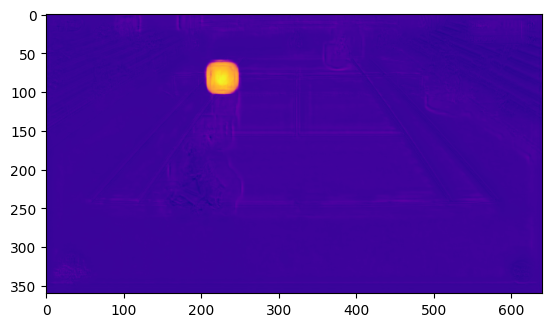

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1371 Epoch without improvment 0/6



100%|██████████| 300/300 [01:40<00:00,  2.99it/s]


Epoch is 17 Total train loss is 0.0732


 13%|█▎        | 10/75 [00:01<00:10,  5.95it/s]

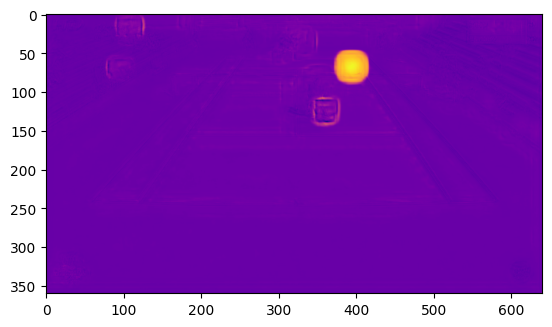

100%|██████████| 75/75 [00:13<00:00,  5.67it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1343 Epoch without improvment 0/6



100%|██████████| 300/300 [01:39<00:00,  3.02it/s]


Epoch is 18 Total train loss is 0.0726


 13%|█▎        | 10/75 [00:01<00:11,  5.68it/s]

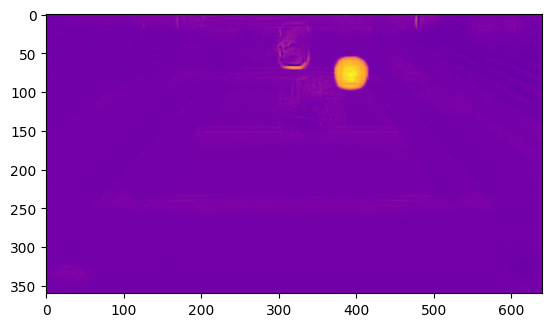

100%|██████████| 75/75 [00:13<00:00,  5.70it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1291 Epoch without improvment 0/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 19 Total train loss is 0.0722


 13%|█▎        | 10/75 [00:01<00:11,  5.81it/s]

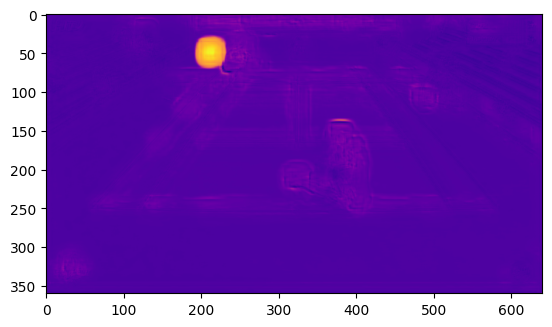

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1465 Epoch without improvment 1/6



100%|██████████| 300/300 [01:39<00:00,  3.02it/s]


Epoch is 20 Total train loss is 0.0717


 13%|█▎        | 10/75 [00:01<00:11,  5.51it/s]

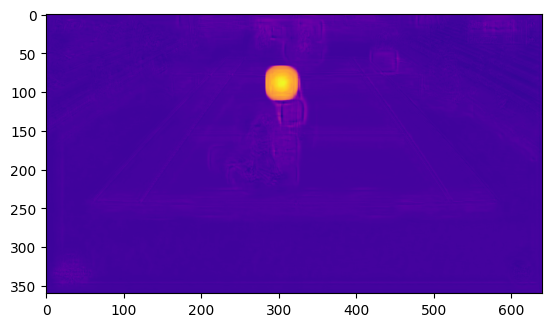

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1377 Epoch without improvment 2/6



100%|██████████| 300/300 [01:40<00:00,  2.97it/s]


Epoch is 21 Total train loss is 0.0722


 13%|█▎        | 10/75 [00:01<00:10,  5.93it/s]

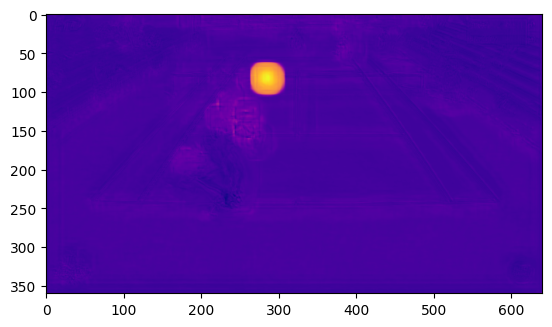

100%|██████████| 75/75 [00:13<00:00,  5.67it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1274 Epoch without improvment 0/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 22 Total train loss is 0.0727


 13%|█▎        | 10/75 [00:01<00:10,  6.01it/s]

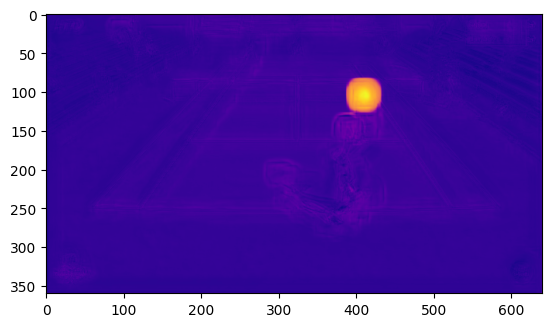

100%|██████████| 75/75 [00:13<00:00,  5.72it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1299 Epoch without improvment 1/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 23 Total train loss is 0.0725


 13%|█▎        | 10/75 [00:01<00:10,  5.95it/s]

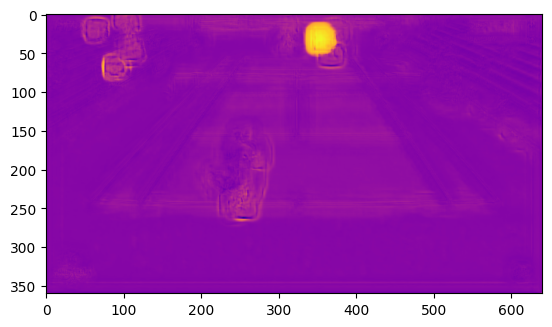

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1325 Epoch without improvment 2/6



100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


Epoch is 24 Total train loss is 0.0722


 13%|█▎        | 10/75 [00:01<00:11,  5.55it/s]

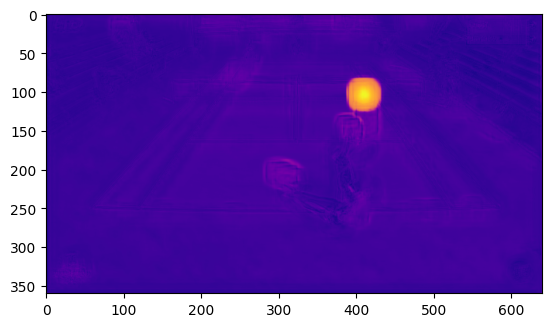

100%|██████████| 75/75 [00:13<00:00,  5.64it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1376 Epoch without improvment 3/6



100%|██████████| 300/300 [01:39<00:00,  3.03it/s]


Epoch is 25 Total train loss is 0.0713


 13%|█▎        | 10/75 [00:01<00:11,  5.76it/s]

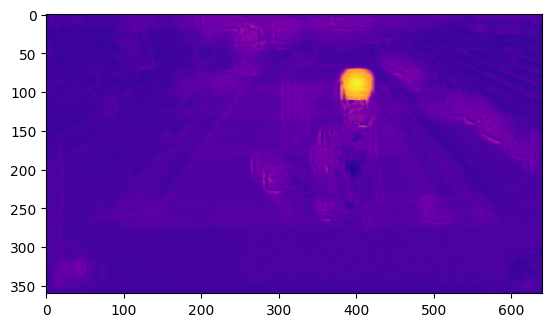

100%|██████████| 75/75 [00:13<00:00,  5.70it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1298 Epoch without improvment 4/6



100%|██████████| 300/300 [01:40<00:00,  3.00it/s]


Epoch is 26 Total train loss is 0.0706


 13%|█▎        | 10/75 [00:01<00:11,  5.73it/s]

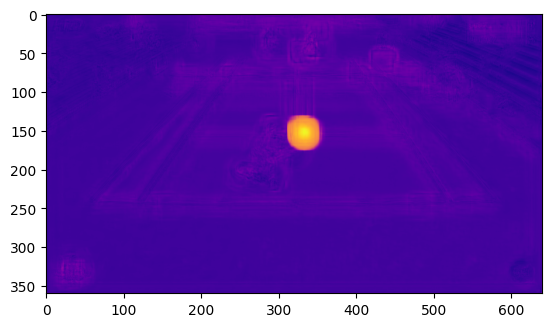

100%|██████████| 75/75 [00:13<00:00,  5.64it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1291 Epoch without improvment 5/6



100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


Epoch is 27 Total train loss is 0.0712


 13%|█▎        | 10/75 [00:01<00:11,  5.89it/s]

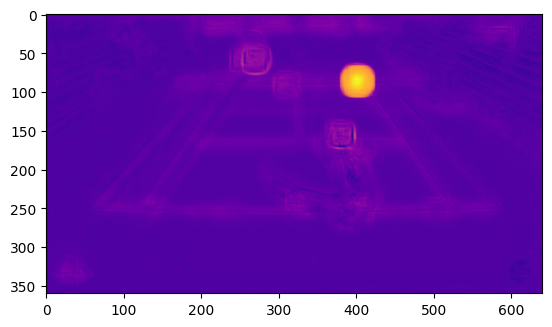

100%|██████████| 75/75 [00:13<00:00,  5.72it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1364 Epoch without improvment 6/6



100%|██████████| 300/300 [01:38<00:00,  3.04it/s]


Epoch is 28 Total train loss is 0.0717


 13%|█▎        | 10/75 [00:01<00:11,  5.90it/s]

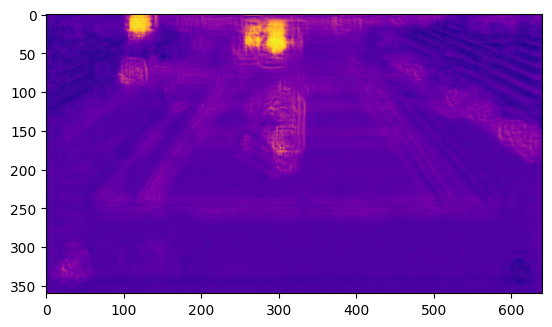

100%|██████████| 75/75 [00:13<00:00,  5.71it/s]


STARTING TO AUGMENT!!!!
Total val loss is 0.1296 Epoch without improvment 7/6

patince is over. training is over. smallestt loss is 0.1274
training done.


In [19]:
model.train_on_data(train_l, val_l, device= device, max_epochs=MAX_EPOCHS, num_of_steps=NUM_OF_STEPS, patience= PATIENCE, lr=LR)

Пример пайплайна для тестирования обученной модели:

In [18]:
if True:
    new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale, threshold = THRESHOLD)
    new_model.load_weights("best_model.pth", device)
    new_model.to(device)
    
else:
    new_model = model
    

In [20]:
# new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)
# new_model.load()
# new_model.load_weights("best_with_augs_1.pth", device)
# new_model.to(device)
new_model.threshold = THRESHOLD
sibatracc_final = new_model.test(Path('data/test'), [1], do_visualization=True, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

loading clip data (game 1, clip 1) downscaled
loading clip data (game 1, clip 1) 
loading clip labels (game 1, clip 1)
doing predictions
stack_s: 8 n_frames: 361
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 2) downscaled
loading clip data (game 1, clip 2) 
loading clip labels (game 1, clip 2)
doing predictions
stack_s: 8 n_frames: 199
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 3) downscaled
loading clip data (game 1, clip 3) 
loading clip labels (game 1, clip 3)
doing predictions
stack_s: 8 n_frames: 36
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 4) downscaled
loading clip data (game 1, clip 4) 
loading clip labels (game 1, clip 4)
doing predictions
stack_s: 8 n_frames: 45
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 5) downscaled
loading clip data (game 1, clip 5) 
loading clip labels (game 1, clip 5)
doing predictions
stack_s: 8 n_fram

# Тест модели 
что бы загрузка заработала нужно запустить все клетки кода от помеченной как Глобальные Переменные и выше и потом запустить код ниже

In [17]:

link = "https://drive.google.com/uc?id=1HYXJpUcQ5ErH3MHSohQm7doIlZZRjt_h"
test_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale, threshold = THRESHOLD)
test_model.to(device)

test_model.load(link, device)

Running stub for loading model ...


Downloading...
From: https://drive.google.com/uc?id=1HYXJpUcQ5ErH3MHSohQm7doIlZZRjt_h
To: d:\tracking_model\model.pth
100%|██████████| 2.12M/2.12M [00:00<00:00, 15.5MB/s]

Loading model done.


In [18]:
sibatracc_final = test_model.test(Path('data/test'), [1, 2], do_visualization=True, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

loading clip data (game 1, clip 1) downscaled
loading clip data (game 1, clip 1) 
loading clip labels (game 1, clip 1)
doing predictions
stack_s: 8 n_frames: 361
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 2) downscaled
loading clip data (game 1, clip 2) 
loading clip labels (game 1, clip 2)
doing predictions
stack_s: 8 n_frames: 199
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 3) downscaled
loading clip data (game 1, clip 3) 
loading clip labels (game 1, clip 3)
doing predictions
stack_s: 8 n_frames: 36
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 4) downscaled
loading clip data (game 1, clip 4) 
loading clip labels (game 1, clip 4)
doing predictions
stack_s: 8 n_frames: 45
predictions are made
perfoming clip visualization
loading clip data (game 1, clip 5) downscaled
loading clip data (game 1, clip 5) 
loading clip labels (game 1, clip 5)
doing predictions
stack_s: 8 n_fram